# Use Pandas to sort and cluster seismic event arrivals CSV files

## Explore the pandas functions, and validate testing the algorithms.

###  Fei Zhang
### Last updated 2019-06-13

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
inputcsv = '/g/data/ha3/fxz547/Githubz/passive-seismic/tests/testdata/100K_ensemble.s.txt'
phase='S'
csv_data = pd.read_csv(inputcsv, sep='\s+', header='infer')

In [3]:
csv_data.head()

,#eventID,originTimestamp,mag,originLon,originLat,originDepthKm,net,sta,cha,pickTimestamp,...,az,baz,distance,ttResidual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma
0,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,WB2,BHZ,1.197052e+09,...,211.307536,33.423870,18.078703,-9.494550,0.0,0.0,0.0,0.0,0,0
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,BWTI,BHZ,1.197052e+09,...,253.419602,76.084999,21.116708,3.440456,0.0,0.0,0.0,0.0,0,0
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,ASAR,BHZ,1.197052e+09,...,206.658314,29.213591,21.465569,-1.246142,0.0,0.0,0.0,0.0,0,0
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,FITZ,BHZ,1.197052e+09,...,231.993295,55.698029,22.630683,-0.416301,0.0,0.0,0.0,0.0,0,0
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,QIZ,BHZ,1.197053e+09,...,305.772809,121.213056,41.203520,0.819049,0.0,0.0,0.0,0.0,0,0


In [4]:
from seismic.traveltime.cluster_grid import Grid2
import seismic.traveltime.sort_rays as sortrays

In [29]:
column_name_map={
    "originLon": "source_lon",
    "originLat": "source_lat",
    "originDepthKm":"source_depth_km",
    "stationLon": "station_lon",
    "stationLat": "station_lat",
    "ttResidual":  "tt_residual"
}

csv_data.rename(columns=column_name_map, inplace=True)

csv_data = sortrays.apply_filters(csv_data, phase)

The initial CSV size= (99999, 23)
After residual cutoff, CSV size= (59363, 24)
After qualityMeasureCWT, CSV size= (59363, 24)
After qualityMeasureSlope, CSV size= (59363, 24)
After nSigma, CSV size= (59363, 24)
Total number of P-Rays = 25309 ['IR_BWTI_smi:local/102160r49' 'IR_ASAR_smi:local/102160r49'
 'AU_FITZ_smi:local/102160r49' 'GE_QIZ_smi:local/102160r49'
 'IR_GYA_smi:local/102160r49']


In [30]:
csv_data.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,distance,tt_residual,snr,qualityMeasureCWT,domFreq,qualityMeasureSlope,bandIndex,nSigma,manual_picks_flag,ray_filter_flag
1,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,BWTI,BHZ,1.197052e+09,...,21.116708,3.440456,0.0,0.0,0.0,0.0,0,0,1,1
2,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,ASAR,BHZ,1.197052e+09,...,21.465569,-1.246142,0.0,0.0,0.0,0.0,0,0,1,1
3,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,AU,FITZ,BHZ,1.197052e+09,...,22.630683,-0.416301,0.0,0.0,0.0,0.0,0,0,1,1
4,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,GE,QIZ,BHZ,1.197053e+09,...,41.203520,0.819049,0.0,0.0,0.0,0.0,0,0,1,1
5,smi:local/102160r49,1.197052e+09,4.8,144.212962,-4.554822,98.8,IR,GYA,BHZ,1.197053e+09,...,47.701178,-1.366003,0.0,0.0,0.0,0.0,0,0,1,1


In [31]:
# the csv size after filters applied:
csv_data.shape

(25554, 25)

In [32]:
mygrid = Grid2(param_file="/g/data/ha3/fxz547/Githubz/passive-seismic/seismic/traveltime/param1x1")


In [33]:
import ellipcorr

from obspy.geodetics import gps2dist_azimuth, locations2degrees
import logging
from seismic.traveltime import pslog
from seismic.traveltime.cluster_grid import Grid2

# DPI = asin(1.0) / 90.0
# R2D = 90. / asin(1.)
# FLOAT_FORMAT = '%.4f'

log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

def compute_ellipticity_corr(arrival_phase, ev_latitude, ev_longitude, ev_depth_km, sta_latitude, sta_longitude,
                             degrees_to_source):
    """
    Utility function to compute ellipticity correction.

    :param arrival_phase: P or S
    :param ev_latitude:  event lat
    :param ev_longitude: event long
    :param ev_depth_km: event depth in km
    :param sta_latitude: station lat
    :param sta_longitude: station long
    :param degrees_to_source: degree to source
    :return: ellipticity correction float value
    """
    myazim = gps2dist_azimuth(ev_latitude, ev_longitude, sta_latitude, sta_longitude)[1]  # [1] shall be taken
    # see https://docs.obspy.org/_modules/obspy/geodetics/base.html#gps2dist_azimuth
    # this function returns 3 values (Great_circle_distance_in_m, azimuth_A->B_in_degrees, azimuth_B->A_in degrees)

    log.debug("Check input params to ellipticity_corr = %s, %s, %s, %s, %s", arrival_phase, degrees_to_source,
              ev_depth_km, 90 - ev_latitude, myazim)

    ellipticity_corr = ellipcorr.ellipticity_corr(
        phase=arrival_phase,
        edist=degrees_to_source,
        edepth=ev_depth_km,
        ecolat=90 - ev_latitude,  # conversion to co-latitude
        azim=myazim
    )

    log.debug("ellipticity_corr = %s", ellipticity_corr)

    return ellipticity_corr


def sort_cluster(csv_data, phase, outputcsv):
    
    
    csv_data['source_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.source_lat, x.source_lon, 1000 * (x.source_depth_km))[0], axis=1)

    csv_data['station_block'] = csv_data.apply(
        lambda x: mygrid.find_block_number(x.station_lat, x.station_lon, 0.0)[0], axis=1)

    csv_data['observed_tt'] = csv_data.pickTimestamp - csv_data.originTimestamp

    # cluster_data.to_csv(outputcsv+"_debug.CSV", header=True, index=False, sep=',')

    log.info('Begin Sorting arrivals.')

    # groupby automatically sorts
    med = csv_data.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(csv_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True, right_index=True)

    # use the following to keep only unique  prim_key: ['source_block', 'station_block']
    # final_df.drop_duplicates(subset=['source_block', 'station_block'],keep='first', inplace=True)
    # Note that some near-by stations may be cluster into one station_block_number, if want to keep stations try
    # final_df.drop_duplicates(subset=['source_block', 'station_block', 'station_code'],keep='first', inplace=True)

    final_df.drop_duplicates(subset=['source_block', 'station_block'], keep='first', inplace=True)

    # elliptic correction to the  observed_travel_time;

    final_df['locations_to_degrees'] = final_df.apply(lambda x: locations2degrees(x.source_lat, x.source_lon,
                                                                                  x.station_lat, x.station_lon), axis=1)
    final_df['my_azim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                    x.station_lat, x.station_lon)[1], axis=1)

    final_df['my_bazim'] = final_df.apply(lambda x: gps2dist_azimuth(x.source_lat, x.source_lon,
                                                                     x.station_lat, x.station_lon)[2], axis=1)
    final_df['ellipticity_corr'] = final_df.apply(lambda x:
                                                  compute_ellipticity_corr(phase, x.source_lat, x.source_lon,
                                                                           x.source_depth_km,
                                                                           x.station_lat, x.station_lon, x.distance),
                                                  axis=1)

    final_df['observed_tt'] = final_df.observed_tt + final_df.ellipticity_corr

    # make sure the originDepth/source_depth is in KM for required by inversion program

    final_df.to_csv(outputcsv, header=True, index=False, sep=',')  # use comma separator,

    # inpdf.to_csv(outputcsv, header=True, index=False, sep=' ')   # mismatch columns in space-delimited csv file as the NaN => empty space !

    if phase == 'P':
        final_df['P_or_S'] = 1
    elif phase == 'S':
        final_df['P_or_S'] = 2
    else:
        raise Exception("Phase must be P or S !!!")

    final_df['event_number'] = final_df.apply(lambda x: int(x.originTimestamp), axis=1)

    # the following values are required for inversion program. the event_number defined as int(originTimestamp)
    # the columns must be in the order:
    required_columns = ['source_block', 'station_block', 'tt_residual', 'event_number',
                        'source_lon', 'source_lat', 'source_depth_km',
                        'station_lon', 'station_lat', 'observed_tt', 'locations_to_degrees', 'P_or_S']

    pdf4inv = final_df[required_columns]

    inv_txt = "%s_inv.txt" % outputcsv
    pdf4inv.to_csv(inv_txt, header=False, index=False, sep=' ', float_format='%.6f')  # space delimitted txt file

    print("Output CSV files = ",outputcsv, inv_txt)
    
    return (final_df, pdf4inv)

In [34]:
pdf1, pdf4 = sort_cluster(csv_data, phase, "%s_sort_cluster.csv"%phase)

Output CSV files =  S_sort_cluster.csv S_sort_cluster.csv_inv.txt


In [35]:
pdf1.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,ray_filter_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
23504,smi:local/22749r11,1.007753e+09,5.7,168.800228,-44.090534,2.302739,AU,FITZ,?,1.007754e+09,...,1,16899,26172,888.532394,44.427709,291.613620,135.299018,0.082394,2,1007753255
23505,smi:local/22749r11,1.007753e+09,5.7,168.800228,-44.090534,2.302739,IR,MAIT,?,1.007754e+09,...,1,16899,7796599,1156.076366,63.947005,188.217773,161.858267,-1.173634,2,1007753255
11510,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,IR,STKA,?,1.283532e+09,...,1,17085,21164,617.153079,26.476455,285.418907,124.343343,-0.156921,2,1283531746
11516,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,IR,ASAR,?,1.283533e+09,...,1,17085,24209,772.941797,36.898094,289.680476,131.580556,-0.038203,2,1283531746
11508,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,G,DZM,?,1.283532e+09,...,1,17085,24814,534.943803,21.796410,345.999789,169.049479,-0.076197,2,1283531746


In [36]:
pdf4.head()

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
23504,16899,26172,0.426409,1007753255,168.800228,-44.090534,2.302739,125.640,-18.0973,888.532394,44.427709,2
23505,16899,7796599,3.420128,1007753255,168.800228,-44.090534,2.302739,11.736,-70.7760,1156.076366,63.947005,2
11510,17085,21164,3.428490,1283531746,171.984919,-43.376180,2.098619,141.595,-31.8763,617.153079,26.476455,2
11516,17085,24209,-3.217092,1283531746,171.984919,-43.376180,2.098619,133.904,-23.6662,772.941797,36.898094,2
11508,17085,24814,1.022202,1283531746,171.984919,-43.376180,2.098619,166.444,-22.0707,534.943803,21.796410,2


In [37]:
print(pdf1.shape, pdf4.shape)

(16718, 34) (16718, 12)


In [13]:
# how about do the clustering and sorting of pdf1 again? they should converge to a fixed CSV.

In [38]:
pdf1_A, pdf4_A = sort_cluster(pdf1, phase, "%s_sort_cluster_A.csv"%phase)

Output CSV files =  S_sort_cluster_A.csv S_sort_cluster_A.csv_inv.txt


In [39]:
print(pdf1_A.shape, pdf4_A.shape)

(16718, 34) (16718, 12)


In [40]:
pdf1_A.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,ray_filter_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
23504,smi:local/22749r11,1.007753e+09,5.7,168.800228,-44.090534,2.302739,AU,FITZ,?,1.007754e+09,...,1,16899,26172,888.532394,44.427709,291.613620,135.299018,0.082394,2,1007753255
23505,smi:local/22749r11,1.007753e+09,5.7,168.800228,-44.090534,2.302739,IR,MAIT,?,1.007754e+09,...,1,16899,7796599,1156.076366,63.947005,188.217773,161.858267,-1.173634,2,1007753255
11510,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,IR,STKA,?,1.283532e+09,...,1,17085,21164,617.153079,26.476455,285.418907,124.343343,-0.156921,2,1283531746
11516,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,IR,ASAR,?,1.283533e+09,...,1,17085,24209,772.941797,36.898094,289.680476,131.580556,-0.038203,2,1283531746
11508,smi:local/193401r68,1.283532e+09,7.3,171.984919,-43.376180,2.098619,G,DZM,?,1.283532e+09,...,1,17085,24814,534.943803,21.796410,345.999789,169.049479,-0.076197,2,1283531746


In [17]:
# how to compare the vaules of two pdf dataframes pdf1 and pdf1_A??



# Alternative Sorting Algorithms

In [18]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'SNR', 'P_or_S']

def sort(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on median of observed travel time.

    If there are multiple source and station block combinations, we keep the
    row corresponding to the median observed travel time (observed_tt).

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: None
    """

#     log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

#     log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(by=['source_block',
                                   'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block',
                                     'event_number', SOURCE_LONGITUDE,
                                     SOURCE_LATITUDE, 'source_depth'],
                             keep='first',
                             inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df


In [19]:
!pwd


/g/data/ha3/fxz547/Githubz/passive-seismic/notebooks


<Figure size 432x288 with 0 Axes>

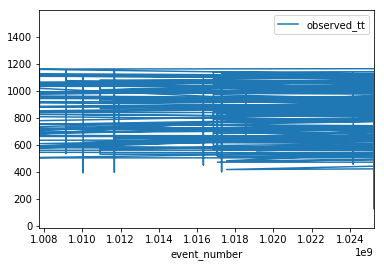

In [41]:
plt.figure(); pdf1.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

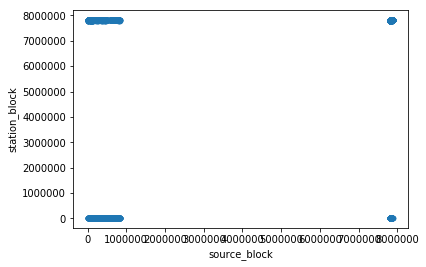

In [42]:
plt.figure(); pdf1.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

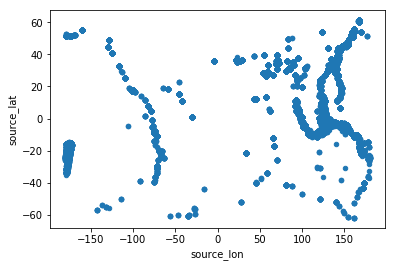

In [43]:
plt.figure(); pdf1.plot.scatter(x='source_lon', y='source_lat')

<Figure size 432x288 with 0 Axes>

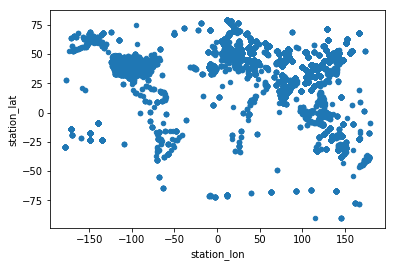

In [44]:
plt.figure(); pdf1.plot.scatter(x='station_lon', y='station_lat')

In [45]:
 med = pdf1.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [46]:
med.head()

,source_block,station_block,observed_tt
0,16899,26172,888.45
1,16899,7796599,1157.25
2,17085,21164,617.31
3,17085,24209,772.98
4,17085,24814,535.02


In [47]:
med.shape

(16718, 3)

In [48]:
pdf1.shape

(16718, 34)

In [49]:
pdf3=csv_data.groupby(by=['source_block', 'station_block']).count()

In [50]:
pdf3.shape

(16718, 26)

In [51]:
pdf3.head()

#eventID  originTimestamp  mag  source_lon  \
source_block station_block                                               
16899        26172                 1                1    1           1   
             7796599               1                1    1           1   
17085        21164                 2                2    2           2   
             24209                 1                1    1           1   
             24814                 2                2    2           2   

                            source_lat  source_depth_km  net  sta  cha  \
source_block station_block                                               
16899        26172                   1                1    1    1    1   
             7796599                 1                1    1    1    1   
17085        21164                   2                2    2    2    2   
             24209                   1                1    1    1    1   
             24814                   2                2    2    2    2   

                            pickTimestamp     ...       tt_residual  snr  \
source_block station_block                    ...                          
16899        26172                      1     ...                 1    1   
             7796599                    1     ...                 1    1   
17085        21164                      2     ...                 2    2   
             24209                      1     ...                 1    1   
             24814                      2     ...                 2    2   

                            qualityMeasureCWT  domFreq  qualityMeasureSlope  \
source_block station_block                                                    
16899        26172                          1        1                    1   
             7796599                        1        1                    1   
17085        21164                          2        2                    2   
             24209                          1        1                    1   
             24814                          2        2                    2   

                            bandIndex  nSigma  manual_picks_flag  \
source_block station_block                                         
16899        26172                  1       1                  1   
             7796599                1       1                  1   
17085        21164                  2       2                  2   
             24209                  1       1                  1   
             24814                  2       2                  2   

                            ray_filter_flag  observed_tt  
source_block station_block                                
16899        26172                        1            1  
             7796599                      1            1  
17085        21164                        2            2  
             24209                        1            1  
             24814                        2            2  

[5 rows x 26 columns]

In [52]:
pdf4=pdf3[(pdf3['tt_residual']>=2)]  # more than one ray in the source->station set of rays

In [53]:
pdf4.shape

(4613, 26)

In [54]:
pdf4.tail()

#eventID  originTimestamp  mag  source_lon  \
source_block station_block                                               
7875846      7802976               2                2    2           2   
             7803104               2                2    2           2   
             7803235               3                3    3           3   
             7803563               2                2    2           2   
             7803809               2                2    2           2   

                            source_lat  source_depth_km  net  sta  cha  \
source_block station_block                                               
7875846      7802976                 2                2    2    2    2   
             7803104                 2                2    2    2    2   
             7803235                 3                3    3    3    3   
             7803563                 2                2    2    2    2   
             7803809                 2                2    2    2    2   

                            pickTimestamp     ...       tt_residual  snr  \
source_block station_block                    ...                          
7875846      7802976                    2     ...                 2    2   
             7803104                    2     ...                 2    2   
             7803235                    3     ...                 3    3   
             7803563                    2     ...                 2    2   
             7803809                    2     ...                 2    2   

                            qualityMeasureCWT  domFreq  qualityMeasureSlope  \
source_block station_block                                                    
7875846      7802976                        2        2                    2   
             7803104                        2        2                    2   
             7803235                        3        3                    3   
             7803563                        2        2                    2   
             7803809                        2        2                    2   

                            bandIndex  nSigma  manual_picks_flag  \
source_block station_block                                         
7875846      7802976                2       2                  2   
             7803104                2       2                  2   
             7803235                3       3                  3   
             7803563                2       2                  2   
             7803809                2       2                  2   

                            ray_filter_flag  observed_tt  
source_block station_block                                
7875846      7802976                      2            2  
             7803104                      2            2  
             7803235                      3            3  
             7803563                      2            2  
             7803809                      2            2  

[5 rows x 26 columns]

In [69]:
# select rows
rowmask= (pdf1['source_block'] == 7875846) & (pdf1['station_block']==7803235)  #select certain rows
pdf5=pdf1.loc[ rowmask ]

In [70]:
pdf5.head()

,#eventID,originTimestamp,mag,source_lon,source_lat,source_depth_km,net,sta,cha,pickTimestamp,...,ray_filter_flag,source_block,station_block,observed_tt,locations_to_degrees,my_azim,my_bazim,ellipticity_corr,P_or_S,event_number
71669,smi:local/67596r11,1.025285e+09,6.6,130.713895,43.761556,568.0,IR,PYA,M?E,1.025286e+09,...,1,7875846,7803235,999.66,59.868625,303.850833,56.539079,-0.402525,2,1025284771


In [79]:
# iloc[] select by row and column numbers as in the CSV table
# loc[] select by index OR by boolean or conditional lookup

# .iloc returns a Pandas Series when one row is selected,
# and a Pandas DataFrame when multiple rows are selected, or if any column in full is selected. 
# To counter this, pass a single-valued list if you require DataFrame output.
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

pdf4_A.iloc[0]


source_block            1.689900e+04
station_block           2.617200e+04
tt_residual             4.264090e-01
event_number            1.007753e+09
source_lon              1.688002e+02
source_lat             -4.409053e+01
source_depth_km         2.302739e+00
station_lon             1.256400e+02
station_lat            -1.809730e+01
observed_tt             8.885324e+02
locations_to_degrees    4.442771e+01
P_or_S                  2.000000e+00
Name: 23504, dtype: float64

In [81]:
pdf4_A.iloc[[0]]

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
23504,16899,26172,0.426409,1007753255,168.800228,-44.090534,2.302739,125.64,-18.0973,888.532394,44.427709,2


In [75]:
rowmask= (pdf4_A['source_block'] == 7875846) & (pdf4_A['station_block']==7803235)  #select certain rows
pdf5=pdf4_A.loc[ rowmask ]

In [76]:
pdf5.head()

,source_block,station_block,tt_residual,event_number,source_lon,source_lat,source_depth_km,station_lon,station_lat,observed_tt,locations_to_degrees,P_or_S
71669,7875846,7803235,-2.863066,1025284771,130.713895,43.761556,568.0,43.058,44.0323,999.257475,59.868625,2


#  Modify the sort function

In [ ]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello from log.info !')


# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df

In [ ]:
mypdf2 = sort2(inputcsv,sortedfile,residual_cutoff)

In [ ]:
mypdf2.shape

In [ ]:
mypdf2.head()

In [ ]:
mypdf = sort2(inputcsv,sortedfile,residual_cutoff)

In [ ]:
mypdf.shape

In [ ]:
mypdf.head()

In [ ]:
# check if any duplicate (source_block,station_block) in the dataframe?  primkey
mypdf3=mypdf.groupby(by=['source_block', 'station_block']).count()

In [ ]:
mypdf3.head()

In [ ]:
mypdf4 = mypdf3[(mypdf3['residual']>1)]

In [ ]:
# check if any duplicate (source_block,station_block)
mypdf4.shape  # no rows now  


In [ ]:
pdf2.loc[2]

In [ ]:
pdf2.iloc[1]

In [ ]:
pdf2.describe()

In [ ]:
pdf2.index

In [ ]:
pdf2.index=pdf2.event_number

In [ ]:
pdf2.index

In [ ]:
pdf2.tail(n=5)

In [ ]:
pdf2.iloc[1]  # now .loc[2] does not work

In [ ]:
#pdf2.loc[215]

In [ ]:
-170%360